### imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
import mlflow
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

!python -V

Python 3.12.7


### configs

In [2]:
# configs
# set the tracking uri to the local sqlite db
mlflow.set_tracking_uri("sqlite:///mlflow.db")
# set the experiment name
mlflow.set_experiment("NYC-taxi-duration-prediction")
# access to the ui
#$ mlflow ui --backend-store-uri sqlite:///mlflow.db

<Experiment: artifact_location='/home/yezer/projects/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1747818150363, experiment_id='1', last_update_time=1747818150363, lifecycle_stage='active', name='NYC-taxi-duration-prediction', tags={}>

### dev

In [6]:
df = pd.read_parquet('./TAXI_DATA_FOLDER/green_tripdata_2023-01.parquet')
df.passenger_count.value_counts()

passenger_count
1.0    54299
2.0     5096
5.0     1772
6.0     1054
3.0      958
4.0      364
0.0      336
7.0        4
9.0        2
8.0        2
Name: count, dtype: int64

### functions

In [7]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


### get X_train, y_train, X_val, y_val

In [9]:
df_train = read_dataframe('./TAXI_DATA_FOLDER/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./TAXI_DATA_FOLDER/green_tripdata_2023-02.parquet')
print(len(df_train), len(df_val))

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

cat = ['PU_DO']
num = ['trip_distance']
target = 'duration'

dv = DictVectorizer()
train_dicts = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
print(X_train.shape[1])
y_train = df_train[target].values
val_dicts = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

65946 62574
5702


### linear regression

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

##### plots

RMSE train: 4.802078183384644
RMSE val: 6.037457085676871


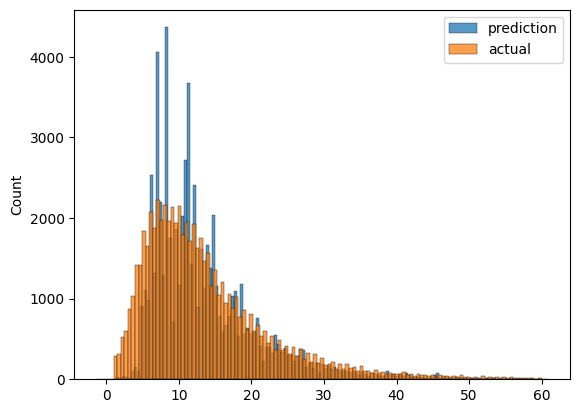

In [11]:
y_pred_train = model.predict(X_train)
print(f'RMSE train: {root_mean_squared_error(y_train, y_pred_train)}')
y_pred_val = model.predict(X_val)
print(f'RMSE val: {root_mean_squared_error(y_val, y_pred_val)}')

sns.histplot(y_pred_train, label='prediction')
sns.histplot(y_train, label='actual')
plt.legend()
plt.show()

##### saving the model

In [12]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pk.dump((model, dv), f_out)

### training Lasso & track mlflow manually (without auto-log)

In [34]:
with mlflow.start_run():

    alpha = 0.002
    mlflow.set_tag("developer", "yezer")
    mlflow.log_param("train-data-path", "./TAXI_DATA_FOLDER/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./TAXI_DATA_FOLDER/green_tripdata_2023-02.parquet")
    mlflow.log_param("alpha", alpha)
    
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    print(f'RMSE train: {root_mean_squared_error(y_train, y_pred_train)}')
    y_pred_val = model.predict(X_val)

    with open('./models/lin_reg.bin', 'wb') as f_out:
        pk.dump((model, dv), f_out)

    print(f'RMSE val: {root_mean_squared_error(y_val, y_pred_val)}')
    mlflow.log_metric("rmse-train", root_mean_squared_error(y_train, y_pred_train))
    mlflow.log_metric("rmse-val", root_mean_squared_error(y_val, y_pred_val))

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")
    print(y_pred_val[:10])
    

RMSE train: 6.837155034194461
RMSE val: 7.117201746440069
[19.31394082 19.31343204 19.31356345 18.63643513 18.49557612 19.31324335
 13.27752829  7.79574141 14.46913883  9.06398161]


##### retrieve an specific model run

In [35]:
import mlflow # Ensure mlflow is imported
import pickle as pk # Ensure pickle is imported as pk, matching earlier notebook usage

RUN_ID = "38735cf8252d4c5e807bc95252684ca3"
ARTIFACT_FILE_PATH = "models_pickle/lin_reg.bin"

# Construct the URI to the specific artifact file
artifact_uri = f"runs:/{RUN_ID}/{ARTIFACT_FILE_PATH}"
print(f"Attempting to download artifact from URI: {artifact_uri}")

# Download the artifact.
downloaded_artifact_path = mlflow.artifacts.download_artifacts(artifact_uri=artifact_uri)
print(f"Artifact downloaded to: {downloaded_artifact_path}")

# Load the model and DictVectorizer from the downloaded pickle file.
with open(downloaded_artifact_path, 'rb') as f_in:
    # Unpack the tuple
    loaded_model_from_pickle, loaded_dv_from_pickle = pk.load(f_in)

# 'loaded_model_from_pickle' is now the scikit-learn Lasso model.
# 'X_val' (from the notebook's global scope) should have been transformed by the 
# DictVectorizer (dv) that was packaged with the model during its training in cell 18.

# Predict using the loaded model
predictions = loaded_model_from_pickle.predict(X_val)
print("Predictions from loaded model (first 10):")
print(predictions[:10])

Attempting to download artifact from URI: runs:/38735cf8252d4c5e807bc95252684ca3/models_pickle/lin_reg.bin
Artifact downloaded to: /home/yezer/projects/mlops-zoomcamp/02-experiment-tracking/mlruns/1/38735cf8252d4c5e807bc95252684ca3/artifacts/models_pickle/lin_reg.bin
Predictions from loaded model (first 10):
[19.31394082 19.31343204 19.31356345 18.63643513 18.49557612 19.31324335
 13.27752829  7.79574141 14.46913883  9.06398161]


### training XGBoost & mlflow
registering different configs using hyperparameters tunning

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 30, 36, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# every iteration, try a different set of hyperparameters defined in the search_space
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=3,
    trials=Trials()
)

##### best xgboost model

In [38]:
# I take the best combination of hyperparameters from the search_space
# I select the model with less rmse.
# I want to train the model and save the model
params = {
    'learning_rate': 0.08679284763755482,
    'max_depth': 32,
    'min_child_weight': 4.502827623121207,
    'objective': 'reg:linear',
    'reg_alpha': 0.01829781988694331,
    'reg_lambda': 0.0033943083795616212,
    'seed': 42
}
# booster = xgb.train(
#     params=params,
#     dtrain=train,
#     num_boost_round=1000,
#     evals=[(valid, "validation")],
#     early_stopping_rounds=50,
# )


# # way 01
# with mlflow.start_run():
#     mlflow.set_tag("model", "xgboost_best")
#     mlflow.log_params(params)
#     booster = xgb.train(
#         params=params,
#         dtrain=train,
#         num_boost_round=1000,
#         evals=[(valid, "validation")],
#         early_stopping_rounds=50,
#     )
#     .......

# or
# way 02
mlflow.xgboost.autolog() #some frameworks have autolog() as xgboost, scikit-learn, etc.
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=50,
)



2025/05/21 15:50:24 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/05/21 15:50:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '60584b1ebed34876977e41a56fe4fe01', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/yezer/projects/mlops-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:50:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:8.78929
[1]	validation-rmse:8.31920
[2]	validation-rmse:7.90568
[3]	validation-rmse:7.54266
[4]	validation-rmse:7.22447
[5]	validation-rmse:6.94830
[6]	validation-rmse:6.70797
[7]	validation-rmse:6.50075
[8]	validation-rmse:6.32156
[9]	validation-rmse:6.16780
[10]	validation-rmse:6.03447
[11]	validation-rmse:5.91955
[12]	validation-rmse:5.82230
[13]	validation-rmse:5.73822
[14]	validation-rmse:5.66569
[15]	validation-rmse:5.60355
[16]	validation-rmse:5.55063
[17]	validation-rmse:5.50572
[18]	validation-rmse:5.46726
[19]	validation-rmse:5.43421
[20]	validation-rmse:5.40647
[21]	validation-rmse:5.37868
[22]	validation-rmse:5.35651
[23]	validation-rmse:5.33761
[24]	validation-rmse:5.32031
[25]	validation-rmse:5.30501
[26]	validation-rmse:5.29260
[27]	validation-rmse:5.28194
[28]	validation-rmse:5.27295
[29]	validation-rmse:5.26405
[30]	validation-rmse:5.25731
[31]	validation-rmse:5.25057
[32]	validation-rmse:5.24460
[33]	validation-rmse:5.24000
[34]	validation-rmse:5.2

2025/05/21 15:51:06 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/21 15:51:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yezer/projects/mlops-zoomcamp/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [15:51:06] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/21 15:51:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/21 15:51:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### five regressors & mlflow

##### Training and track

In [8]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from time import time

with open('./models/preprocessor.b', 'wb') as f_out:
    pk.dump(dv, f_out)

# whether enable, it tracks a lot of metrics.
mlflow.sklearn.autolog(disable=True)

# If I don't use this, the model will be trained with the default parameters, takes too long
model_configs = {
    GradientBoostingRegressor: {'n_estimators': 50, 'max_depth': 10},
    ExtraTreesRegressor: {'n_estimators': 50, 'max_depth': 20, 'n_jobs': -1},
    LinearSVR: {'max_iter': 2000, 'dual': False, 'loss': 'squared_epsilon_insensitive'},
    RandomForestRegressor: {'n_estimators': 50, 'max_depth': 20, 'n_jobs': -1}
}
for model_class in (GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR, RandomForestRegressor):

    with mlflow.start_run():
        print(f'Training {model_class.__name__}')
        mlflow.set_tag("developer", "yezer")
        mlflow.set_tag("model", model_class.__name__)
        mlflow.set_tags({"developer": "yezer", "model": model_class.__name__})
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        # Log model configuration parameters
        mlflow.log_params(model_configs[model_class])

        mlmodel = model_class(**model_configs[model_class])
        t0 = time()
        mlmodel.fit(X_train, y_train)
        t_time = time() - t0
        print(f'Training time: {t_time}')
        mlflow.sklearn.log_model(
                mlmodel, artifact_path="models_mlflow"
            )

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

Training GradientBoostingRegressor
Training time: 22.760976552963257


2025/04/08 13:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training ExtraTreesRegressor
Training time: 19.184048175811768


2025/04/08 13:26:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training LinearSVR
Training time: 7.444507598876953


2025/04/08 13:26:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training RandomForestRegressor
Training time: 24.518590211868286


2025/04/08 13:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
